# Lid Driven Cavity: solving the Navier-Stokes equations
In this notebook we solve the incompressible Navier Stokes equations in a lid-driven cavity scenario using Finite Differences, explicit timestepping and Chorin's Projection.

Here are the equations:

#### Momentum:           ∂u/∂t + (u ⋅ ∇) u = − 1/ρ ∇p + ν ∇²u + f

#### Incompressibility:  ∇ ⋅ u = 0

u:  Velocity (2d vector)\
p:  Pressure\
f:  Forcing (here =0)\
ν:  Kinematic Viscosity\
ρ:  density\
t:  Time\
∇:  Nabla operator (defining nonlinear convection, gradient and divergence)\
∇²: Laplace Operator

We are dealing with  physical scenario of this kind:

We want to reproduce the current flow and the pressure gradient of the problem using python. 
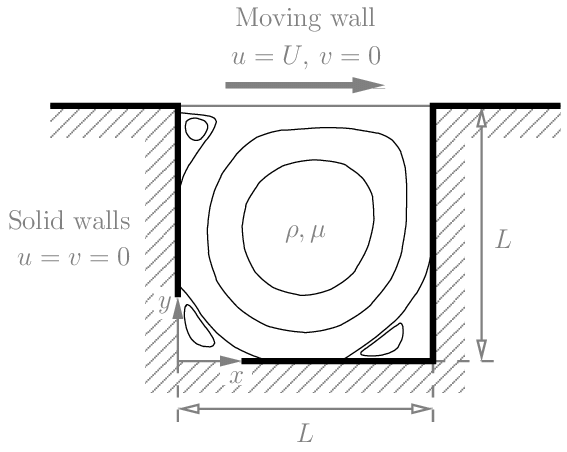

* Velocity and pressure have zero initial condition.
* Homogeneous Dirichlet Boundary Conditions everywhere except for horizontal
  velocity at top. It is driven by an external flow.

-----

Solution strategy:   (Projection Method: Chorin's Splitting)

1. Solve Momentum equation without pressure gradient for tentative velocity
   (with given Boundary Conditions)

    ∂u/∂t + (u ⋅ ∇) u = ν ∇²u

2. Solve pressure poisson equation for pressure at next point in time
   (with homogeneous Neumann Boundary Conditions everywhere except for
   the top, where it is homogeneous Dirichlet)

    ∇²p = ρ/Δt ∇ ⋅ u           

3. Correct the velocities (and again enforce the Velocity Boundary Conditions)

    u ← u − Δt/ρ ∇ p

-----
We expect that after some time iterations a swirling motion will take place. 

The problem is 2-dimensional. We may write the strategy in index notation. 

u = [u, v]
x = [x, y]

1. Solve tentative velocity + velocity BC

    ∂u/∂t + u ∂u/∂x + v ∂u/∂y = ν ∂²u/∂x² + ν ∂²u/∂y²

    ∂v/∂t + u ∂v/∂x + v ∂v/∂y = ν ∂²v/∂x² + ν ∂²v/∂y²

2. Solve pressure poisson + pressure BC

    ∂²p/∂x² + ∂²p/∂y² = ρ/Δt (∂u/∂x + ∂v/∂y)

3. Correct velocity + velocity BC

    u ← u − Δt/ρ ∂p/∂x

    v ← v − Δt/ρ ∂p/∂y

First import some useful libraries.

The library "tqdm" is used to visualize computation progress with a bar. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

Initial values for our variables.\
We use an explicity scheme, thus we need to state the number of iterations we will employ to solve the equations numerically.\
Later we will play around with the assigned values, minding that we need to select a timestep that ensures stability. 

In [2]:
n_points = 41
domain_size = 1.0
iterations = 500
timestep = 0.001
kin_viscosity = 0.1 # ν
density = 1.0  # ρ
lid_velocity = 1.0

N_PRESSURE_POISSON_ITERATIONS = 50
STABILITY_SAFETY_FACTOR = 0.5

element_length = domain_size / (n_points - 1) # avoid including both boundary points 
x = np.linspace(0.0, domain_size, n_points)
y = np.linspace(0.0, domain_size, n_points)

X, Y = np.meshgrid(x, y)

u_prev = np.zeros_like(X) # velocities are zero in the beginning 
v_prev = np.zeros_like(X)
p_prev = np.zeros_like(X)

Now we define the differential operators in a discretized way. 

In [3]:
def central_difference_x(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = ( # exclude the boundaries  
            f[1:-1, 2:  ]  
            -
            f[1:-1, 0:-2]
        ) / (
            2 * element_length
        )
        return diff
    
def central_difference_y(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (
        f[2:  , 1:-1]
        -
        f[0:-2, 1:-1]
    ) / (
        2 * element_length
    )
    return diff
    
def laplace(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (
        f[1:-1, 0:-2]
        +
        f[0:-2, 1:-1]
        -
        4
        *
        f[1:-1, 1:-1]
        +
        f[1:-1, 2:  ]
        +
        f[2:  , 1:-1]
    ) / (
        element_length**2
    )
    return diff

Let's add some constraints to ensure the solving scheme is stable. We will obtain a warning message if we choose bad values. 

In [4]:
maximum_possible_timestep = (
        0.5 * element_length**2 / kin_viscosity
    )
if timestep > STABILITY_SAFETY_FACTOR * maximum_possible_timestep:
    raise RuntimeError("Stability is not guaranteed")

In [16]:
for _ in tqdm(range(iterations)): # range in progress over iterations 
    d_u_prev__d_x = central_difference_x(u_prev)
    d_u_prev__d_y = central_difference_y(u_prev)
    d_v_prev__d_x = central_difference_x(v_prev)
    d_v_prev__d_y = central_difference_y(v_prev)
    laplace__u_prev = laplace(u_prev)
    laplace__v_prev = laplace(v_prev)

    # Perform a tentative step by solving the momentum equation without the pressure gradient
    u_tent = (
        u_prev
        +
        timestep * (
            -
            ( 
                u_prev * d_u_prev__d_x
                +
                v_prev * d_u_prev__d_y
            )
            +
            kin_viscosity * laplace__u_prev
        )
    )
    v_tent = (
        v_prev
        +
        timestep * (
            -
            (
                u_prev * d_v_prev__d_x
                +
                v_prev * d_v_prev__d_y
            )
            +
            kin_viscosity * laplace__v_prev
        )
    )
    
    # ENFORCE BOUNDARY CONDITIONS 
    # Velocity Boundary Conditions: Homogeneous Dirichlet BC everywhere
    # except for the horizontal velocity at the top = lid_velocity 
    u_tent[0, :] = 0.0
    u_tent[:, 0] = 0.0
    u_tent[:, -1] = 0.0
    u_tent[-1, :] = lid_velocity
    v_tent[0, :] = 0.0
    v_tent[:, 0] = 0.0
    v_tent[:, -1] = 0.0
    v_tent[-1, :] = 0.0

    # take derivatives 
    d_u_tent__d_x = central_difference_x(u_tent)
    d_v_tent__d_y = central_difference_y(v_tent)

    # Compute a pressure correction by solving the pressure-poisson equation
    rhs = (
        density / timestep
        *
        (
            d_u_tent__d_x
            +
            d_v_tent__d_y
        )
    )

    # Iterate over the pressure Poisson iterations to solve for the pressure field.
    # In each iteration:
    #   1. Compute the updated pressure field based on the previous pressure field and the right-hand side.
    #   2. Apply boundary conditions to ensure homogeneous Neumann boundary conditions.
    #   3. Set the pressure on the bottom boundary to zero as a homogeneous Dirichlet boundary condition.
    #   4. Update the previous pressure field with the newly computed pressure field for the next iteration.
    for _ in range(N_PRESSURE_POISSON_ITERATIONS):
        p_next = np.zeros_like(p_prev)
        p_next[1:-1, 1:-1] = 1/4 * (
            +
            p_prev[1:-1, 0:-2]
            +
            p_prev[0:-2, 1:-1]
            +
            p_prev[1:-1, 2:  ]
            +
            p_prev[2:  , 1:-1]
            -
            element_length**2
            *
            rhs[1:-1, 1:-1]
        )

        # Pressure Boundary Conditions: Homogeneous Neumann Boundary
        p_next[:, -1] = p_next[:, -2] # pressure on the walls is equal to previous step pressure 
        p_next[0,  :] = p_next[1,  :]
        p_next[:,  0] = p_next[:,  1]
        p_next[-1, :] = 0.0 # pressure on the bottom is zero 

        p_prev = p_next
    
    # compute pressure gradient 
    d_p_next__d_x = central_difference_x(p_next)
    d_p_next__d_y = central_difference_y(p_next)

    # correct the velocities such that the fluid stays incompressible
    u_next = (
        u_tent
        -
        timestep / density
        *
        d_p_next__d_x
    )
    v_next = (
        v_tent
        -
        timestep / density
        *
        d_p_next__d_y
    )
 
    # enforce boundary conditions for "next velocities"
    u_next[0, :] = 0.0
    u_next[:, 0] = 0.0
    u_next[:, -1] = 0.0
    u_next[-1, :] = lid_velocity
    v_next[0, :] = 0.0
    v_next[:, 0] = 0.0
    v_next[:, -1] = 0.0
    v_next[-1, :] = 0.0

    # advance in time
    u_prev = u_next
    v_prev = v_next
    p_prev = p_next

100%|███████████████████████████████████████████| 500/500 [00:00<00:00, 651.03it/s]


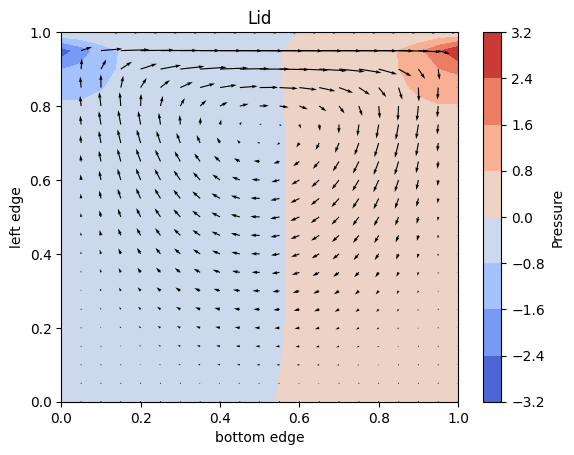

In [17]:
plt.figure()
plt.contourf(X[::2, ::2], Y[::2, ::2], p_next[::2, ::2], cmap="coolwarm")
plt.colorbar(label='Pressure')

plt.xlabel('bottom edge')
plt.ylabel('left edge')
plt.title('Lid')

# Add streamlines
plt.quiver(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
#plt.streamplot(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")

# Set plot limits
plt.xlim((0, 1))
plt.ylim((0, 1))

plt.show()